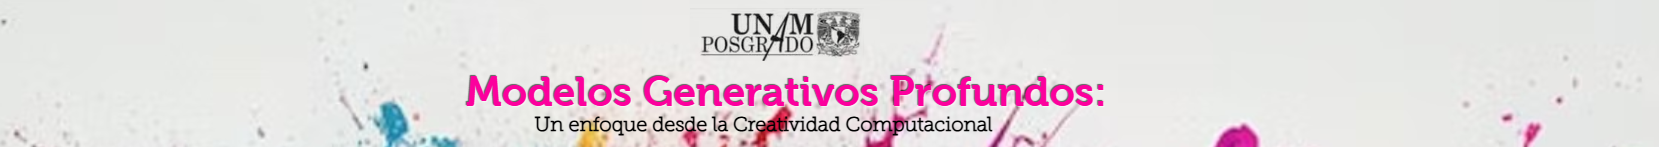

# CVAE - Fashion-MNIST

En este cuaderno recorreremos los pasos necesarios para entrenar un
**Conditional Variational Autoencoder (CVAE)** sobre el conjunto de
datos *Fashion-MNIST*. A diferencia del VAE estándar, aquí aprenderemos
a condicionar el proceso generativo en las etiquetas de las imágenes, lo
que nos permitirá muestrear nuevas prendas controlando explícitamente la
clase (por ejemplo, generar únicamente "dresses").

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm
from tensorflow.keras.utils import to_categorical


## 0. Parámetros

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500
num_classes = 10  # Fashion-MNIST

## 1. Preparar los datos

En la versión **VAE** solo necesitábamos las imágenes para entrenar el modelo.
Ahora, al pasar a un **CVAE**, también debemos cargar las etiquetas o atributos asociados, ya que forman parte esencial del condicionamiento.


In [ ]:
# Cargar los datos
# Antes solo cargábamos las imágenes sin las etiquetas.
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Preprocesar los datos


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

<p>
  En un <strong>CVAE</strong> necesitamos que las etiquetas estén en un formato adecuado para concatenarlas con el vector latente.
  Por ello, convertimos las clases enteras en <em>vectores one-hot</em> usando <code>to_categorical</code>.
  De esta forma, cada etiqueta pasa de ser un número entero (ej. <code>3 = vestido</code>) a un vector binario de longitud igual al número de clases, donde solo una posición vale 1.
</p>

<p><strong>Ejemplo:</strong></p>
<p><code>Clase 3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]</code></p>


In [ ]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

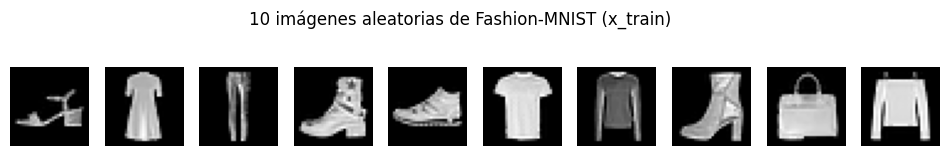

In [ ]:
# Muestra algunas imágenes del dataset

# Seleccionar 10 índices aleatorios
idx = np.random.choice(len(x_train), size=10, replace=False)

plt.figure(figsize=(12, 2))
for i, img_idx in enumerate(idx):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[img_idx].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("10 imágenes aleatorias de Fashion-MNIST (x_train)")
plt.show()


## 2. Construir el VAE

<p>
En un <strong>CVAE</strong>, la clase <code>Sampling</code> no necesita modificaciones respecto al <strong>VAE</strong>.  
Su función es aplicar la <em>reparametrización</em>:
</p>

<p style="text-align:center;">
  z = z<sub>mean</sub> + exp(0.5 · z<sub>log_var</sub>) · ε, &nbsp; ε ~ N(0, I)
</p>

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

<p>
En el <strong>CVAE</strong>, el codificador recibe no solo la imagen, sino también la
<strong>etiqueta codificada en one-hot</strong>.  
Después de extraer las características de la imagen mediante convoluciones,
estas se <em>concatenan</em> con el vector de etiqueta antes de calcular
<code>z_mean</code> y <code>z_log_var</code>.  
De esta manera, el espacio latente queda condicionado explícitamente por la clase.
</p>


In [ ]:
# Codificador
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)

# --- Entrada de etiqueta (one-hot vector) --- <----------------
label_input = layers.Input(shape=(num_classes,), name="label_input")

# --- Bloque convolucional sobre la imagen ---
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

# --- Concatenar con la etiqueta --- <----------------
x = layers.Concatenate()([x, label_input])

# --- Variables latentes ---
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

# --- Definir el modelo del encoder --- <----------------
encoder = models.Model([encoder_input, label_input],
                       [z_mean, z_log_var, z],
                       name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2058)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,118 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,118 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,908 (394.17 KB)

 Trainable params: 100,908 (394.17 KB)

 Non-trainable params: 0 (0.00 B)

<p>
En el <strong>decodificador del CVAE</strong>, el vector latente <code>z</code> se
<strong>concatena con la etiqueta one-hot</strong> antes de iniciar la reconstrucción.  
De esta forma, la condición guía el proceso generativo desde el inicio.  
El modelo proyecta la combinación de <code>z</code> y la etiqueta en una forma inicial,
que luego es expandida mediante <em>capas deconvolucionales</em> hasta recuperar la
dimensión de la imagen original.  
La salida final corresponde a la imagen reconstruida, condicionada explícitamente
por la clase seleccionada.
</p>


In [ ]:
# Decodificador

# Entrada latente (z)
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Entrada de etiqueta (one-hot) <----------------
label_input = layers.Input(shape=(num_classes,), name="label_input_decoder")

# Concatenar z con la etiqueta <----------------
x = layers.Concatenate()([decoder_input, label_input])

# Proyección inicial densa
x = layers.Dense(np.prod(shape_before_flattening))(x)
x = layers.Reshape(shape_before_flattening)(x)

# Bloques deconvolucionales
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)


# Salida final
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)


# Modelo del decoder condicional
decoder = models.Model([decoder_input, label_input], decoder_output, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input_decoder │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12)        │          0 │ decoder_input[0]… │
│ (Concatenate)       │                   │            │ label_input_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │     26,624 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 128) │    147,584 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │     73,792 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │     18,464 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 32, 32, 1) │        289 │ conv2d_transpose… │
│ (Conv2D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 266,753 (1.02 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

<p>
La clase <strong>CVAE</strong> define el modelo de autoencoder variacional condicional.  
Integra el <em>encoder</em> y el <em>decoder</em>, permitiendo que tanto la codificación
como la decodificación estén guiadas por las etiquetas.  
Durante el entrenamiento se calculan dos pérdidas principales:
</p>

<ul>
  <li><strong>Pérdida de reconstrucción</strong>: mide qué tan similar es la imagen generada a la original,
      condicionada por la etiqueta.</li>
  <li><strong>Pérdida KL</strong>: regulariza el espacio latente para que siga una distribución gaussiana estándar,
      asegurando continuidad y capacidad de muestreo.</li>
</ul>

<p>
La combinación de ambas pérdidas entrena el CVAE para generar imágenes que no solo sean
visualmente consistentes, sino también coherentes con la condición especificada.  
La clase también define <code>train_step</code> y <code>test_step</code> personalizados,
lo que permite controlar explícitamente el cálculo de estas pérdidas y el seguimiento de métricas.
</p>


In [ ]:
# Clase CVAE:
# Implementa un autoencoder variacional condicional.
# Combina encoder y decoder condicionados por etiquetas,
# y define train_step/test_step con pérdidas de reconstrucción y KL.
class CVAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=False):
        """
        inputs = [imagen, etiqueta]
        """
        img, label = inputs
        z_mean, z_log_var, z = self.encoder([img, label], training=training)
        reconstruction = self.decoder([z, label], training=training)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """
        data = ([imagenes, etiquetas], imagenes)
        """
        (img, label), target = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self([img, label], training=True)

            # Pérdida de reconstrucción (suma por pixel)
            reconstruction_loss = tf.reduce_mean(
                BETA * tf.reduce_sum(
                    losses.binary_crossentropy(target, reconstruction),
                    axis=(1, 2)  # suma sobre filas y columnas
                )
            )

            # Pérdida KL
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        data = ([imagenes, etiquetas], imagenes)
        """
        (img, label), target = data
        z_mean, z_log_var, reconstruction = self([img, label], training=False)

        reconstruction_loss = tf.reduce_mean(
            BETA * tf.reduce_sum(
                losses.binary_crossentropy(target, reconstruction),
                axis=(1, 2)
            )
        )

        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [ ]:
# Crear un Conditional Variational Autoencoder
cvae = CVAE(encoder, decoder)

## 3. Entrenamiento del VAE

In [ ]:
# Compilar el CVAE
optimizer = optimizers.Adam(learning_rate=0.0005)
cvae.compile(optimizer=optimizer)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/model_cvae.keras"
log_dir = "/content/drive/MyDrive/logs"

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
cvae.fit(
    [x_train, y_train_cat],   # imágenes + etiquetas one-hot
    x_train,                  # target = imagen original
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=([x_test, y_test_cat], x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - kl_loss: 18.1725 - reconstruction_loss: 188396.6406 - total_loss: 188414.8438 - val_kl_loss: 21.7090 - val_loss: 134341.0938 - val_reconstruction_loss: 134319.3906
Epoch 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - kl_loss: 20.0164 - reconstruction_loss: 129607.4219 - total_loss: 129627.4766 - val_kl_loss: 17.0159 - val_loss: 131011.5625 - val_reconstruction_loss: 130994.5469
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 16.9375 - reconstruction_loss: 126976.1094 - total_loss: 126993.0312 - val_kl_loss: 15.8074 - val_loss: 129713.1016 - val_reconstruction_loss: 129697.2969
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 15.8522 - reconstruction_loss: 125695.7109 - total_loss: 125711.5391 - val_kl_loss: 15.0304 - val_loss: 128658.4922 - val_reconstruction_loss: 128643.4609
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 15.0701 - reconstruction_loss: 125486.4297 - total_loss: 125501.5312 - val_kl_loss: 14.3120 - val_loss: 128701.8125 - val_reconstruction_loss: 128687.5000


In [ ]:
# Salva los modelos finales
import os

drive_path = "/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase11_autoencoders_II"

cvae.save(os.path.join(drive_path, "autoencoder_cvae_fashion.keras"))
encoder.save(os.path.join(drive_path, "encoder_cvae_fashion.keras"))
decoder.save(os.path.join(drive_path, "decoder_cvae_fashion.keras"))


## 3. Muestrear imágenes condicionales

3.1 Definir un helper para muestreo condicional

In [ ]:
# Mapeo de etiquetas de Fashion-MNIST
fashion_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def generar_condicional(decoder, num_samples, clase, latent_dim=EMBEDDING_DIM):
    """
    Genera imágenes de Fashion-MNIST condicionadas a una clase específica.
    - decoder: tu decodificador entrenado
    - num_samples: número de imágenes a generar
    - clase: índice de la clase (0–9 en Fashion-MNIST)
    - latent_dim: dimensión del espacio latente
    """
    # 1. Muestreo aleatorio de z
    z_samples = np.random.normal(size=(num_samples, latent_dim))

    # 2. Crear etiqueta one-hot
    labels = np.zeros((num_samples, 10))
    labels[:, clase] = 1

    # 3. Decodificar
    generated = decoder.predict([z_samples, labels])

    # 4. Mostrar imágenes
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generación condicional: clase {clase} - {fashion_classes[clase]}")
    plt.show()


3.2 Probar con una clase específica

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


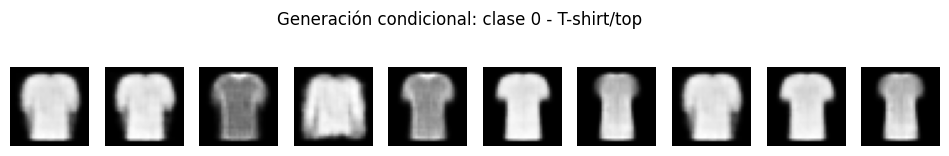

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


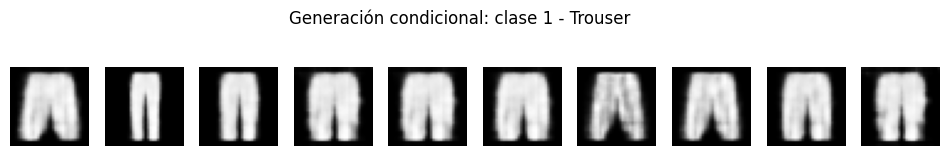

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


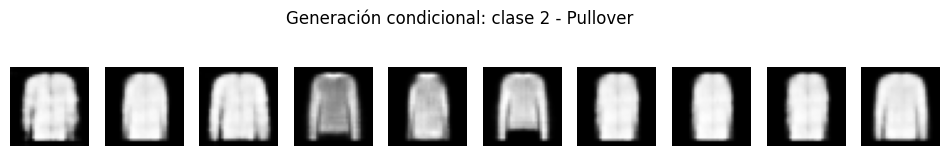

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


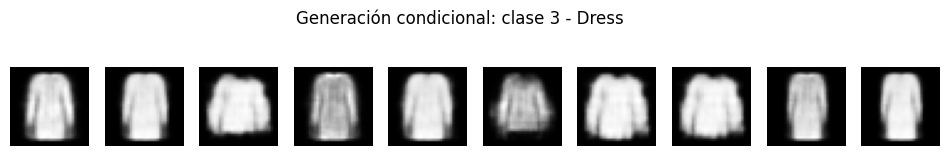

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


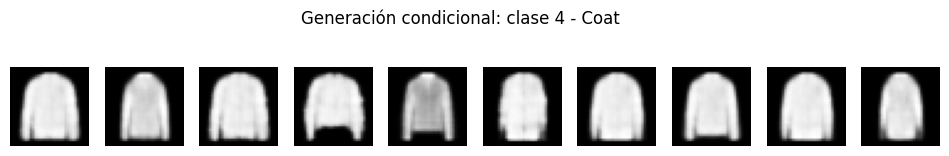

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


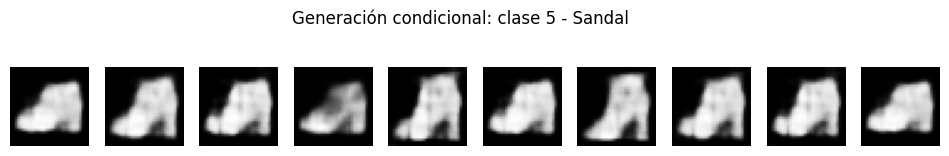

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


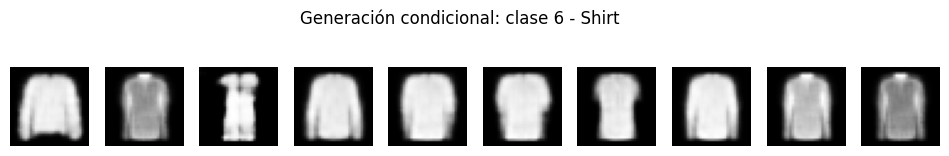

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


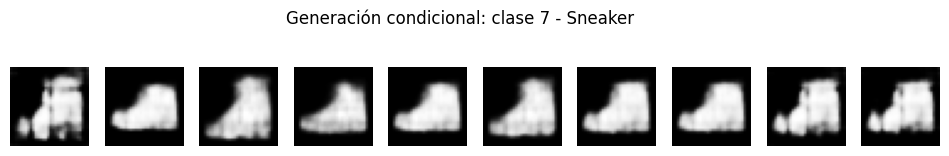

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


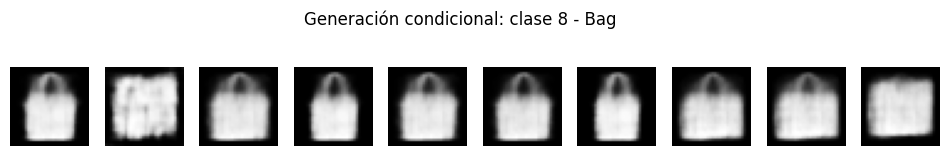

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


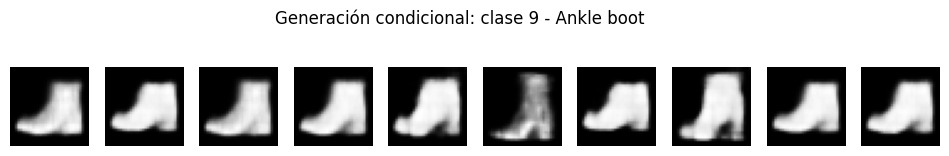

In [ ]:
# Generar 10 imágenes de cada clase de Fashion-MNIST
for clase in range(10):
    generar_condicional(decoder, num_samples=10, clase=clase)
